# HackerEarth Deep Learning Challenge 1 : Predicting the Product Category

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.misc import *

In [3]:
import os,sys
from PIL import Image
import cv2
from tqdm import tqdm

In [4]:
DATA_HOME_DIR = os.getcwd()
%pwd

'/output'

## Reading the image labels

In [5]:
train = pd.read_csv("/data/train.csv")
test = pd.read_csv("/data/test.csv")

In [6]:
train.head()

,image_id,label
0,train_1a,rice
1,train_1b,candy
2,train_1c,jam
3,train_1d,coffee
4,train_2a,vinegar


In [7]:
train.groupby(by = "label").count()

,image_id
label,
beans,88
cake,105
candy,242
cereal,181
chips,118
chocolate,199
coffee,194
corn,63
fish,71


In [8]:
## set path for images
TRAIN_PATH = '/data/train_img/'
TEST_PATH = '/data/test_img/'

Let's check out a few images from the training set along with their labels. 
Resizing pixelates the text part of the image.

In [9]:
# function to read images as arrays
def read_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (256,256))
    return img

In [10]:
train_data = []
test_data = []
train_labels = train['label'].values

for img in tqdm(train['image_id'].values):
    train_data.append(read_image(TRAIN_PATH + '{}.png'.format(img)))
    
for img in tqdm(test['image_id'].values):
    test_data.append(read_image(TEST_PATH + '{}.png'.format(img)))

100%|██████████| 1732/1732 [00:40<00:00, 41.42it/s]


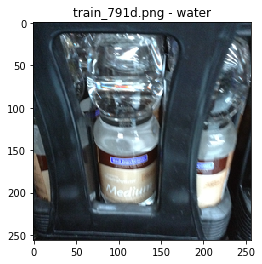

In [11]:
i = np.random.choice(np.arange(len(train_data)))

plt.title('{}.png - {}'.format(train['image_id'].values[i], train_labels[i]))
plt.imshow(train_data[i])

In [12]:
# Scale the images
X_train = np.array(train_data, np.float32) / 255.
X_test = np.array(test_data, np.float32) / 255.

In [13]:
# Encoding image labels into target variables (categorical)
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le = LabelEncoder()
y_train = le.fit_transform(train_labels)

ohe = OneHotEncoder(categorical_features = [0])
y_train = ohe.fit_transform(y_train.reshape(-1,1)).toarray()

In [15]:
## Reshaping train and test images
#X_train = X_train.reshape(X_train.shape[0], 3, 64, 64)
#X_test = X_test.reshape(X_test.shape[0], 3, 64, 64)

In [14]:
X_train.shape, y_train.shape

((3215, 256, 256, 3), (3215, 25))

Let's train simple Keras CNN models

In [15]:
# Importing the Keras libraries and packages
import keras
from keras import applications
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

Using Theano backend.
Using cuDNN version 5110 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)


### Model 1 : Transfer Learning with ImageNet pre-trained models (VGG16/ResNet/Inception models etc.)

In [25]:
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [18]:
last_layer = base_model.get_layer('block5_pool')

for i in range(base_model.layers.index(last_layer)):
    base_model.layers[i].trainable = False

In [26]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [51]:
## set model architechture 
add_model = Sequential([
            Flatten(input_shape=base_model.output_shape[1:]),
            Dense(256, activation='relu'),
            Dense(y_train.shape[1], activation='softmax')
            ])

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer = SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

In [52]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [30]:
# Training the model
model.fit(X_train, y_train, batch_size=32, epochs=2, validation_split=0.2)

Train on 2572 samples, validate on 643 samples
Epoch 1/2
2572/2572 [==============================] - 497s - loss: 2.6533 - acc: 0.2523 - val_loss: 2.3603 - val_acc: 0.3017
Epoch 2/2
2572/2572 [==============================] - 498s - loss: 1.8910 - acc: 0.4479 - val_loss: 1.9928 - val_acc: 0.3997


 Let's try out data augmentation using ImageDataGenerator to reduce overfitting. The above model (pre-trained VGG16) started overfitting in just about 3 epochs. 

In [42]:
from sklearn.cross_validation import train_test_split
X_trn, X_valid, y_trn, y_valid = train_test_split(X_train, y_train, test_size = 0.2)

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [43]:
gen = image.ImageDataGenerator(rotation_range=25, width_shift_range=0.1, shear_range=0.25,
                               height_shift_range=0.1, zoom_range=0.2, horizontal_flip = True)
batches = gen.flow(X_trn, y_trn, batch_size = 32)
val_batches = gen.flow(X_valid, y_valid, batch_size = 64)

In [ ]:
model.fit_generator(batches, (X_trn.shape[0]//batches.batch_size), epochs=4,
                    validation_data = val_batches, validation_steps = (X_valid.shape[0]//val_batches.batch_size))

Epoch 1/4
80/80 [==============================] - 496s - loss: 2.5186 - acc: 0.2681 - val_loss: 2.4095 - val_acc: 0.3040
Epoch 2/4
80/80 [==============================] - 495s - loss: 2.0884 - acc: 0.3789 - val_loss: 2.1929 - val_acc: 0.3558
Epoch 3/4
80/80 [==============================] - 495s - loss: 1.8158 - acc: 0.4570 - val_loss: 1.8624 - val_acc: 0.4439
Epoch 4/4
80/80 [==============================] - 495s - loss: 1.5835 - acc: 0.5305 - val_loss: 1.7909 - val_acc: 0.4750


In [ ]:
model.save_weights('pre-trained_vgg-16_weights.h5')

### Making predictions on test set

In [31]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis= 1)

In [32]:
predictions[13:21]

array([13, 10,  2, 24, 17,  6,  4, 20])

In [33]:
unique_labels = np.unique(train['label'].tolist())

In [34]:
# Converting predicted category numbers to predicted labels
pred_labels = unique_labels[predictions]

I see this product is milk


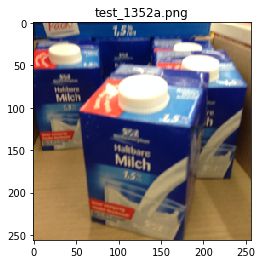

In [38]:
## lets see what our classifier predicts on test images
# Random predictions
i = np.random.choice(np.arange(len(test_data)))
print('I see this product is {}'.format(pred_labels[i]))
plt.title('{}.png'.format(test['image_id'].values[i]))
plt.imshow(Image.open(TEST_PATH +'{}.png'.format(test.image_id[i])))

In [39]:
# Prepare submission file
subm = pd.DataFrame({'image_id':test.image_id, 'label':pred_labels})
subm.to_csv('results.csv', index=False)